# Histopathologic Cancer Detection

## Introduction


Early and accurate cancer detection is critical for improving patient outcomes. Traditional methods relying on human expertise are time-consuming and prone to errors. The increasing volume of histopathological images further exacerbates this challenge. 

This project aims to develop a deep learning-based model capable of accurately classifying histopathological images as cancerous or non-cancerous. By leveraging the Histopathologic Cancer Detection dataset, we will explore the potential of deep learning techniques to assist doctors in their diagnostic process. Successful implementation of this model could significantly enhance cancer diagnosis efficiency and contribute to advancements in medical image analysis.

### Setup

Import Tensorflow and other necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

print(tf.__version__)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.16.1


### Data

PatchCamelyon (PCam) packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. 

The [data](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) for this project is a slightly modified version of the PCam benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

## Exploratory Data Analysis

In [3]:
import pathlib

data_path = '../input/histopathologic-cancer-detection/train'
test_path = '../input/histopathologic-cancer-detection/test'
data_dir = pathlib.Path(data_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(data_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

print(len(train_imgs))
print(len(test_imgs))

220025
57458


The dataset uses total 220025 training images, and 57458 images for testing, its too large, we'll select a subset of images for training and validation later.

#### Preview Images

Now take a look at a few pictures to get a better sense of what the dataset look like.

In [3]:
# Get training and testing files
train_files = os.listdir(data_dir)
test_files = os.listdir(test_dir)

print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])

Training image files: 
['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif', '5a32933e093185f5fc91d30fc83ad571c6818d25.tif', '42e77d193e73811e0bb65a0cbd9b01c5c27900fa.tif', '27bb898f54a0b9345f6c4a9083299e4465860861.tif', '89cd55e4300440612347c38f306da688a166fd40.tif', 'cd600f77aa2af7c93dc6cd836e44edada3d8c403.tif']
Testing image files: 
['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif', 'd23c66547f4a00555a174d2fcb860ae399b66edc.tif', 'fabf2fca23f71655974767e29eda86a9b2c97a72.tif', '9730b15862516b8641b9f0ff48db660d95031c32.tif', 'ee85348c0950c2e639776fb555e3452c1f8437c0.tif', 'ef12a0813c504d2d1b2ba485e78d380ad64a0622

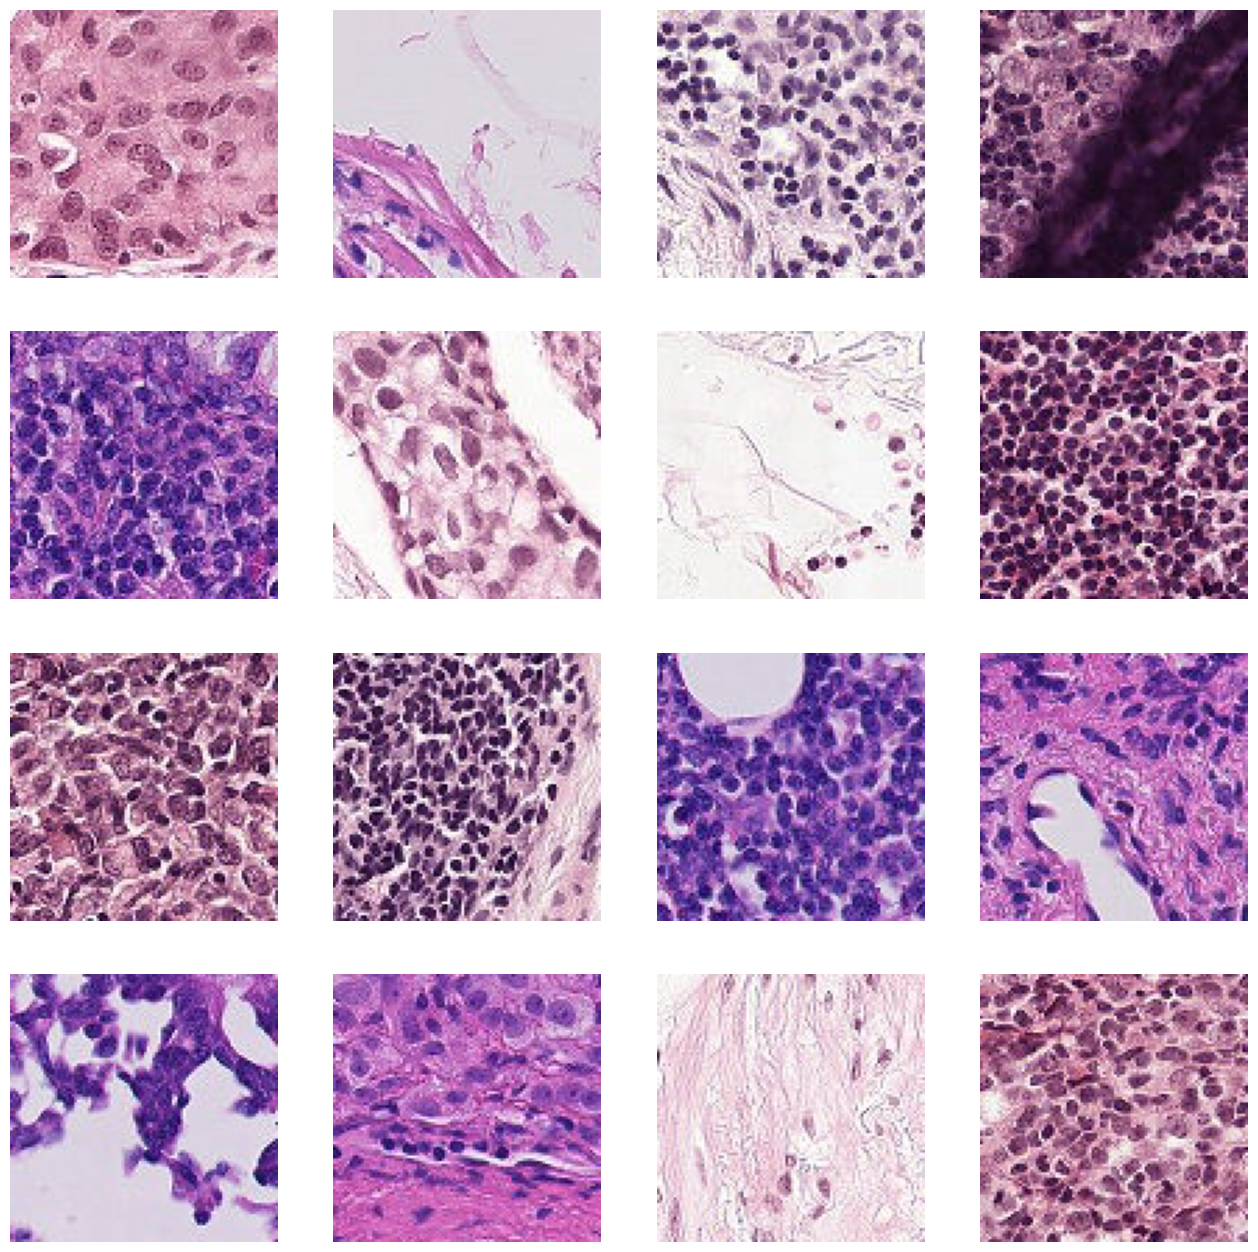

In [4]:
# Create a 4x4 plot
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_train_pix = [os.path.join(data_dir, file)
                for file in train_files[pic_index-8:pic_index]]
next_test_pix = [os.path.join(test_dir, file)
                for file in test_files[pic_index-8:pic_index]]

for i, img_path in enumerate(next_train_pix+next_test_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### Data Preprocessing

There are total 220025 images in the train folder, it's a large dataset, we'll select a subset of them for testing and validation.

The image file type is `.tif`, which is not an supported file type with the `keras.utils.image_dataset_from_directory` function. Fortunately, the `ImageDataGenerator` could help, also we could utilize the `ImageDataGenerator` provided the `flow_from_dataframe` function to create training and validation data.

In [14]:
# from sklearn.model_selection import train_test_split
# # from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
# from PIL import Image

# # Define constants
# IMG_SIZE = 384  # EfficientNetV2S recommended input size
# BATCH_SIZE = 32
# EPOCHS = 10

# # load labels dataframe
# df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
# df['image_path'] = df['id'].apply(lambda x: os.path.join(data_dir, x + '.tif'))

# # Split the data
# train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# # Create dataset loading function
# def load_and_preprocess_image(file_path, label):
#     img = tf.io.read_file(file_path)
#     img = tf.py_function(lambda x: np.array(Image.open(x.decode()).convert('RGB').resize((IMG_SIZE, IMG_SIZE))), [img], tf.uint8)
#     img.set_shape([IMG_SIZE, IMG_SIZE, 3])
#     img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
# #     img = preprocess_input(img)
#     return img, label

# # Create tf.data.Dataset objects
# def create_dataset(dataframe):
#     ds = tf.data.Dataset.from_tensor_slices((dataframe['image_path'].values, dataframe['label'].values))
#     ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
#     return ds

# train_ds = create_dataset(train_df)
# train_ds = train_ds.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# val_ds = create_dataset(val_df)
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Select Train & Validation Samples

To maintain data balance, we'll randomly sample 20000 images from the dataset. Of these, 10000 will have a label of 1, while the remaining 10000 will have a label of 0.

In [36]:
# load labels dataframe
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# Filter samples with the label
pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

train_pos_df = pos_df.sample(n=8000, random_state=42)
train_neg_df = neg_df.sample(n=8000, random_state=42)
train_df = pd.concat([train_pos_df, train_neg_df])
# Shuffle the dataframe
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Shuffle the dataframe
val_df = df.sample(n=4000, random_state=42).reset_index(drop=True)

# Add file type
train_df.id = train_df.id + '.tif'
train_df.label = train_df.label.astype(str)

val_df.id = val_df.id + '.tif'
val_df.label = val_df.label.astype(str)

train_df.head()

,id,label
0,5a6c04240a177d907dd83632d43af8a3046a97b5.tif,0
1,59ce4239eeb2b7439937b1abf7b178b11546f207.tif,1
2,f666406058970c03353a6d9016c7d07addf746cd.tif,1
3,df1225d9626643caff34480ee2e40155f2dcfab2.tif,1
4,16a40941e12a02dc22b44ef8dcb7a2b31eacf0be.tif,0


#### Setup Data Generators

Let's setup training and validation data generators. The generators will yield batches of 32 images of size 96x96 and their labels.

We'll use the `keras.preprocessing.image.ImageDataGenerator` class to create generators and using the rescale parameter to normalizing the pixel values to be in the [0,1] range (from original [0, 255] range).

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define batch size and image size
batch_size = 32
img_size = (96, 96)
img_shape = img_size + (3,)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create Image Generator in batches of 32
def create_generator(datagen: ImageDataGenerator, df: pd.DataFrame):
    return datagen.flow_from_dataframe(
        directory = data_dir,
        dataframe = df,
        x_col = 'id',
        y_col = 'label',
        target_size=img_size,
        batch_size=batch_size,
        class_names=['0', '1'],
        class_mode='binary')

train_generator = create_generator(train_datagen, train_df)
val_generator = create_generator(val_datagen, val_df)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


## Model

### Build a Baseline Model

The images that will go into our convnet are 96x96 color images.

In [38]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 96x96x3: 96x96 stands for image height x width pixels, 
# and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=img_shape)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it are two fully-connected layers. Because we are facing binary classification problem, we will end our network with a sigmoid activation function, so that the output of our network will be a single scalar 0 or 1, indicates the probability the image label is 0 or 1.

In [39]:
# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
before_output = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(before_output)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model:

In [40]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,409 (12.59 MB)

 Trainable params: 3,301,409 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

The Output shape column shows how the size of our feature map evolves in each successive layer. We can observe that the convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, let's configure the sepecifications for model training. Since we're facing a binary classification problem, we'll select the `BinaryCrossentropy` loss and use the `Adam` optimizer, also monitoring the classification accuracy during the training.

In [41]:
def compile_model():
    model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])
compile_model()

### Training

Let's train our model for 20 epochs, using 50 batches of training data and 12 batches of validation data per epoch. The `history` object used to capture information during the training.

In [42]:
epochs=10
def fit_model():
    return model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        verbose=2
    )
    
history = fit_model()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 - 81s - 163ms/step - accuracy: 0.7423 - auc_4: 0.8143 - loss: 0.5305 - val_accuracy: 0.7387 - val_auc_4: 0.8671 - val_loss: 0.5292
Epoch 2/10
500/500 - 48s - 95ms/step - accuracy: 0.7764 - auc_4: 0.8547 - loss: 0.4758 - val_accuracy: 0.7958 - val_auc_4: 0.8806 - val_loss: 0.4411
Epoch 3/10
500/500 - 49s - 97ms/step - accuracy: 0.7872 - auc_4: 0.8693 - loss: 0.4533 - val_accuracy: 0.8152 - val_auc_4: 0.8907 - val_loss: 0.4140
Epoch 4/10
500/500 - 48s - 95ms/step - accuracy: 0.8019 - auc_4: 0.8806 - loss: 0.4348 - val_accuracy: 0.8257 - val_auc_4: 0.9048 - val_loss: 0.4088
Epoch 5/10
500/500 - 47s - 94ms/step - accuracy: 0.8081 - auc_4: 0.8874 - loss: 0.4231 - val_accuracy: 0.8230 - val_auc_4: 0.9113 - val_loss: 0.3857
Epoch 6/10
500/500 - 46s - 93ms/step - accuracy: 0.8214 - auc_4: 0.9028 - loss: 0.3953 - val_accuracy: 0.8315 - val_auc_4: 0.9047 - val_loss: 0.3888
Epoch 7/10
500/500 - 47s - 94ms/step - accuracy: 0.8441 - auc_4: 0.9189 - loss: 0.3633 - val_accuracy: 0.8050 - val_

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random training or testing image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


/tmp/ipykernel_1572/3996580876.py:38: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/tmp/ipykernel_1572/3996580876.py:41: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


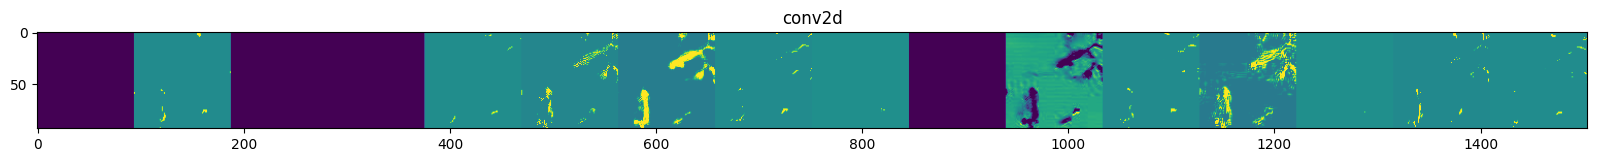

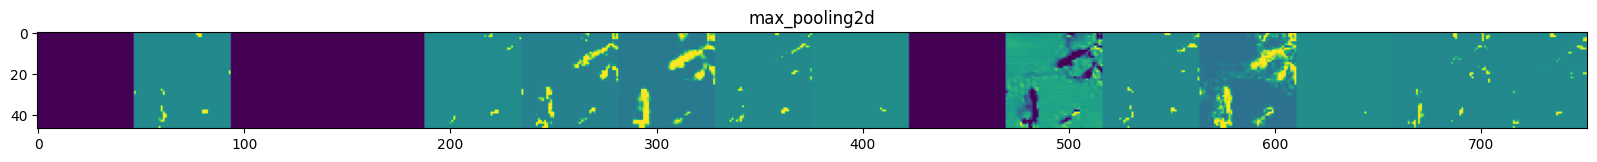

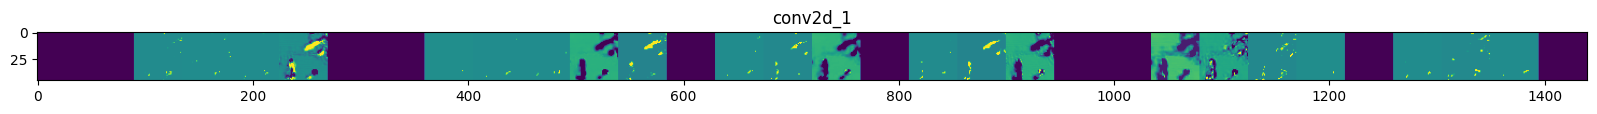

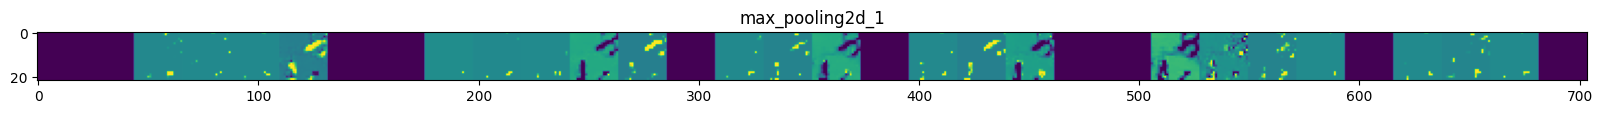

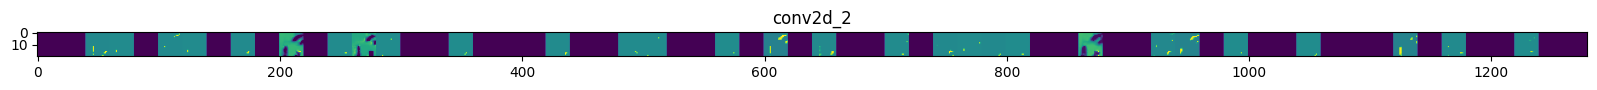

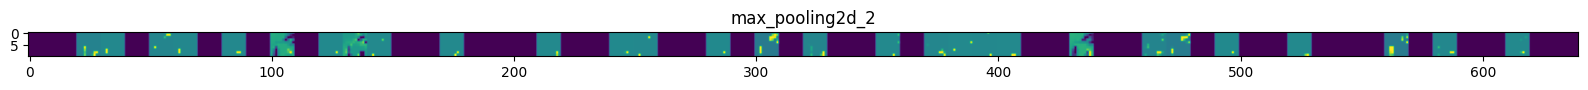

In [12]:
import random
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image from the training set.
img_path = random.choice(train_imgs)

img = keras.utils.load_img(img_path, target_size=img_size)  # this is a PIL image
x = keras.utils.img_to_array(img)  # Numpy array with shape (96, 96, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 96, 96, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Results And Analysis

### Evaluate Accuracy and Loss for the Baseline Model

Let's plot the training and validation accuracy and loss during training:

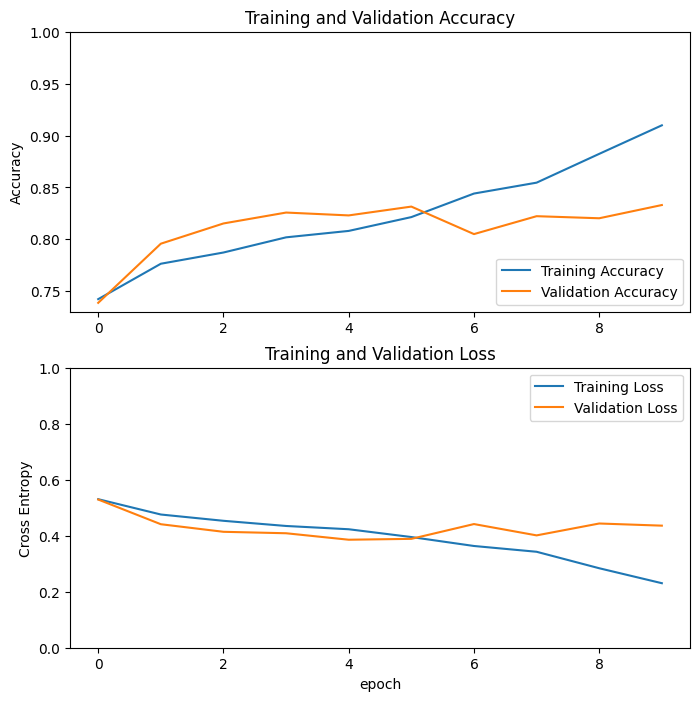

In [43]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = []
val_acc = []
loss = []
val_loss = []
def preview_accuracy():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

preview_accuracy()

Below are the observation from the figure:

- Performance: Both training and validation accuracies are generally close to 80%, which indicates decent performance, however, there's room for improvement.
- Convergence: The accuracies seems to stabilize somewhat towards the end, this is a good indicator.
- Overfitting: There's a little gap between training and validation accuracy，this suggests low degree of overfitting.
- Consistency: Both training and validation accuracies show consistency.

OK, this is baseline model, let's try another state-of-the-art model -- EfficientNetV2.

In [45]:
# Create training data generator with some transformations
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = create_generator(train_datagen, train_df)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(before_output)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)

Found 16000 validated image filenames belonging to 2 classes.


In [46]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,409 (12.59 MB)

 Trainable params: 3,301,409 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 - 102s - 204ms/step - accuracy: 0.8058 - auc_5: 0.8844 - loss: 0.4295 - val_accuracy: 0.7960 - val_auc_5: 0.9147 - val_loss: 0.4586
Epoch 2/10
500/500 - 96s - 192ms/step - accuracy: 0.8236 - auc_5: 0.8985 - loss: 0.4054 - val_accuracy: 0.7903 - val_auc_5: 0.8931 - val_loss: 0.4824
Epoch 3/10
500/500 - 97s - 193ms/step - accuracy: 0.8244 - auc_5: 0.9027 - loss: 0.3972 - val_accuracy: 0.8065 - val_auc_5: 0.8977 - val_loss: 0.4288
Epoch 4/10
500/500 - 98s - 196ms/step - accuracy: 0.8323 - auc_5: 0.9067 - loss: 0.3885 - val_accuracy: 0.8428 - val_auc_5: 0.9206 - val_loss: 0.3640
Epoch 5/10
500/500 - 100s - 200ms/step - accuracy: 0.8292 - auc_5: 0.9096 - loss: 0.3823 - val_accuracy: 0.7825 - val_auc_5: 0.8950 - val_loss: 0.5399
Epoch 6/10
500/500 - 97s - 195ms/step - accuracy: 0.8336 - auc_5: 0.9103 - loss: 0.3817 - val_accuracy: 0.8403 - val_auc_5: 0.9318 - val_loss: 0.3560
Epoch 7/10
500/500 - 99s - 198ms/step - accuracy: 0.8361 - auc_5: 0.9129 - loss: 0.3760 - val_accuracy: 0.826

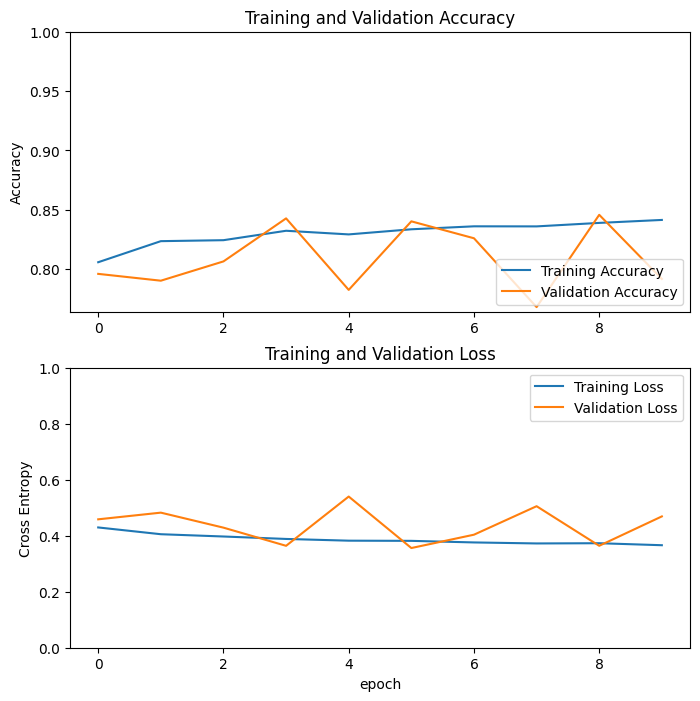

In [47]:
compile_model()
history = fit_model()
preview_accuracy()

### Try EfficientNetV2S Model

EfficientNet is a family of convolutional neural network (CNN) architectures designed to achieve state-of-the-art accuracy while being computationally efficient. Unlike previous methods that arbitrarily scaled network depth, width, or resolution, EfficientNet introduces a compound scaling method that uniformly scales all three dimensions.

EfficientNetV2 is an improved version of the EfficientNet architecture, designed to be even faster to train and more parameter-efficient while maintaining or even surpassing the accuracy of its predecessor.



## Prepare data

In [103]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import tensorflow_io as tfio

# Define constants
IMG_SIZE = 384  # EfficientNetV2S recommended input size
BATCH_SIZE = 32
EPOCHS = 10

train_df['image_path'] = df['id'].apply(lambda x: os.path.join(data_dir, x + '.tif'))
val_df['image_path'] = df['id'].apply(lambda x: os.path.join(data_dir, x + '.tif'))

# # Convert labels to numerical values
# train_df['label'] = pd.Categorical(train_df['label']).codes
# val_df['label'] = pd.Categorical(val_df['label']).codes

def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
#     img = tf.image.grayscale_to_rgb(img)  # Ensure 3 channels
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    img = preprocess_input(img)
    return img, label

# Create tf.data.Dataset objects
def create_dataset(dataframe):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image_path'].values, dataframe['label'].values))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_df)
train_ds = train_ds.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = create_dataset(val_df)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Transfer learning

Let's instantiate a EfficientNetV2S model pre-loaded with weights trained on `ImageNet` first. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [99]:
from tensorflow.keras.applications import EfficientNetV2S


# Load pre-trained EfficientNetV2S model
base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3))

Then we create data augmentation layers to reduce overfitting, and use efficientnet_v2 `preprocess_input` method to rescale the images pixel values from [0, 255] to [-1, 1].

In [100]:
from tensorflow.keras import layers, models

# Freeze the base model
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])


# Create the full model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

final_model = models.Model(inputs, outputs)

Build `base_model` and feature extractor layers using the Keras Functional API.

In [19]:
# # Use training=False as our model contains a BatchNormalization layer.
# x = base_model(x, training=False)
# # Using Pooling layer to convert the features to a single 1280-element vector per image
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# # Apply Dense layer to convert these features into a single prediction per image.
# predictions = layers.Dense(1, activation='sigmoid')(x)

# final_model = Model(inputs=img_input, outputs=predictions)

Let's take a look at the efficientnet model architecture:

In [82]:
final_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 12, 12, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,495,457 (78.18 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
# Compile the model
# final_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC()]
# )

final_model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

# # Callbacks
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
# )
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=10, restore_best_weights=True
# )

# Train the model
history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
#     callbacks=[lr_scheduler, early_stopping]
)

preview_accuracy()

Epoch 1/10


2024-08-23 08:26:59.053977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_33_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Much better! The EfficientNetV2S model give significant higher training & validation accuracies and smaller loss values. We will use the EfficientNetV2S to make prediction.

#### Fine-tuning

In the transfer learning part, the weights of the pre-trained network were not updated during the training.

One way to increase performance even further is to fine-tune the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [ ]:
# Un-freeze the top layers
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    # Freeze all the layers before the `fine_tune_at` layer
    layer.trainable = False

final_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = final_model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_generator)

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the EfficientNetV2S base model and training the classifier on top of it. 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Save the fine-tuning model
final_model.save('efficientnetv2s_binary_classification_model.h5')

### Submission

Let's use the `final_model` to make prediction:

In [ ]:
test_path = '../input/histopathologic-cancer-detection/test'

df_test = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
df_test['filename'] = df_test.id + '.tif'

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_path,
    x_col = 'filename',
    batch_size = batch_size,
    shuffle = False,
    class_mode = None,
    target_size = img_size,
)

predictions = final_model.predict(test_generator)

Apply predictions to submission dataframe:

In [ ]:
df_test.label = np.where(predictions > 0.5, 1, 0)
df_test.head()

Write dataframe to submission csv file:

In [ ]:
df_test.to_csv('submission.csv', columns=['id', 'label'], header = True, index = False)

## Conclusion

This project aimed to explore the ConvNet models for Histopathologic Cancer Detection. The EfficientNetV2S model achieved 85% average accuracy on the validation dataset, surpassing the baseline model. 

We first build basemodel and achieve decent accuracies for training and validation data set, in order to further improve the accuracy, we select a SOTA EfficientNetV2 model, and apply transfer learning from a pre-trained network, add a new classifier on top of the pretrained model and retrain the model, the result shows significant higher accuracy, while the model demonstrated promising results, further improvements could be achieved by exploring fine-tuning.

Although the model shows good accuracy and consistency, there is still fluctuation in accuracy. There may be some noise in the dataset. We can further adopt anomaly detection methods to clean up the anomalies and reduce the fluctuation in accuracy.

## Reference

- [Keras Functional API](https://www.tensorflow.org/guide/keras/functional)
- [Tensorflow: Classification](https://www.tensorflow.org/tutorials/images/classification)
- [Tensorflow: Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
- [Tensorflow: Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946) (ICML 2019)
- [Meta Pseudo Labels](https://paperswithcode.com/paper/meta-pseudo-labels) (CVPR 2021)